# **Virtual Arrow Keys using Gesture Recognition**

  Very Fun Project that translates gestures to arrow key presses that can be used to play games or doom scroll

  Authors: Ashwin Rajesh and Joel Manesh


### Import Packages and Set Constants

In [1]:
!wget https://github.com/tensorflow/tensorflow/archive/v2.14.0.zip
!unzip v2.14.0.zip &> 0
!mv tensorflow-2.14.0/ tensorflow/

!pip install -U tf_keras # Keras 2
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import zipfile
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import files
from IPython.display import Image, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import PIL
import math
import glob
import json

!apt-get update && apt-get -qq install xxd

--2024-12-12 09:04:59--  https://github.com/tensorflow/tensorflow/archive/v2.14.0.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tensorflow/tensorflow/zip/refs/tags/v2.14.0 [following]
--2024-12-12 09:05:00--  https://codeload.github.com/tensorflow/tensorflow/zip/refs/tags/v2.14.0
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v2.14.0.zip’

v2.14.0.zip             [           <=>      ]  89.27M  10.2MB/s    in 9.1s    

2024-12-12 09:05:09 (9.78 MB/s) - ‘v2.14.0.zip’ saved [93606267]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 7

In [2]:
# Define filenames and set up directory structure


MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand")
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand_float.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand.tfl")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand.cc")


In [3]:
NUM_GESTURES = 4 # UPDATE THIS WITH THE NUMBER OF UNIQUE GESTURES IN YOUR DATASET #

Import the Training and Validation Dataset

In [5]:
import sys


# Create Labels
# Define the base array for each group
group1 = np.tile([1, 0, 0, 0], (25, 1))
group2 = np.tile([0, 1, 0, 0], (25, 1))
group3 = np.tile([0, 0, 1, 0], (25, 1))
group4 = np.tile([0, 0, 0, 1], (25, 1))

# Concatenate the groups to form the final array
train_labels = np.vstack((group1, group2, group3, group4))
val_labels = np.vstack((group2, group1, group3, group4))


train_ds = np.load("training_data.npy");
val_ds = np.load("training_data_v2.npy");



# # Number of images per group
# group_size = 25

# # Number of groups
# num_groups = train_ds.shape[0] // group_size

# # Number of images to select from each group
# num_selected = 5

# # Create an array to store selected images
# selected_images = []

# # Loop through each group and select images
# for i in range(num_groups):
#     start_idx = i * group_size
#     end_idx = start_idx + group_size
#     group_images = val_ds[start_idx:end_idx]

#     # Randomly select `num_selected` images from the group
#     selected_indices = np.random.choice(group_size, num_selected, replace=False)
#     selected_images.append(group_images[selected_indices])

# # Combine selected images into a new array
# selected_images = np.concatenate(selected_images, axis=0)

# val_ds = selected_images



train_ds = train_ds.reshape(100, 32, 32, 3)
val_ds = val_ds.reshape(100, 32, 32, 3)
print(train_ds.shape)
print(val_ds.shape)


train_sample = train_ds[89]
np.set_printoptions(threshold=sys.maxsize)

test_str = np.char.mod('%d', train_sample)
final_str = ""
#combine to a string
for i in range(train_sample.shape[0]):
  temp_str = ""
  for j in range(train_sample.shape[1]):
    temp_str += "{" + ",".join(test_str[i][j]) + "}"
    if (j < train_sample.shape[1] - 1):
      temp_str += ",\n"
  final_str += "{" + temp_str + "}"

  #final_str += "{" + ",".join(test_str[i]) + "}"
  if i < train_sample.shape[0] - 1:
    final_str += ",\n"

#final_str = "{\n" + final_str + "\n}"
#print(train_sample)
#print(final_str)

# to_be_written = f"extern char img_arr[{train_sample.shape[0]}][{train_sample.shape[1]}][{train_sample.shape[2]}] = {{{final_str}}};"

# a = open('data_sample.cc', 'w')
# a.write(to_be_written)
# a.close()

#print(to_be_written)
#print(train_ds.shape)
#print(train_labels)


(100, 32, 32, 3)
(100, 32, 32, 3)


Display Training and Validation Data

train_ds:


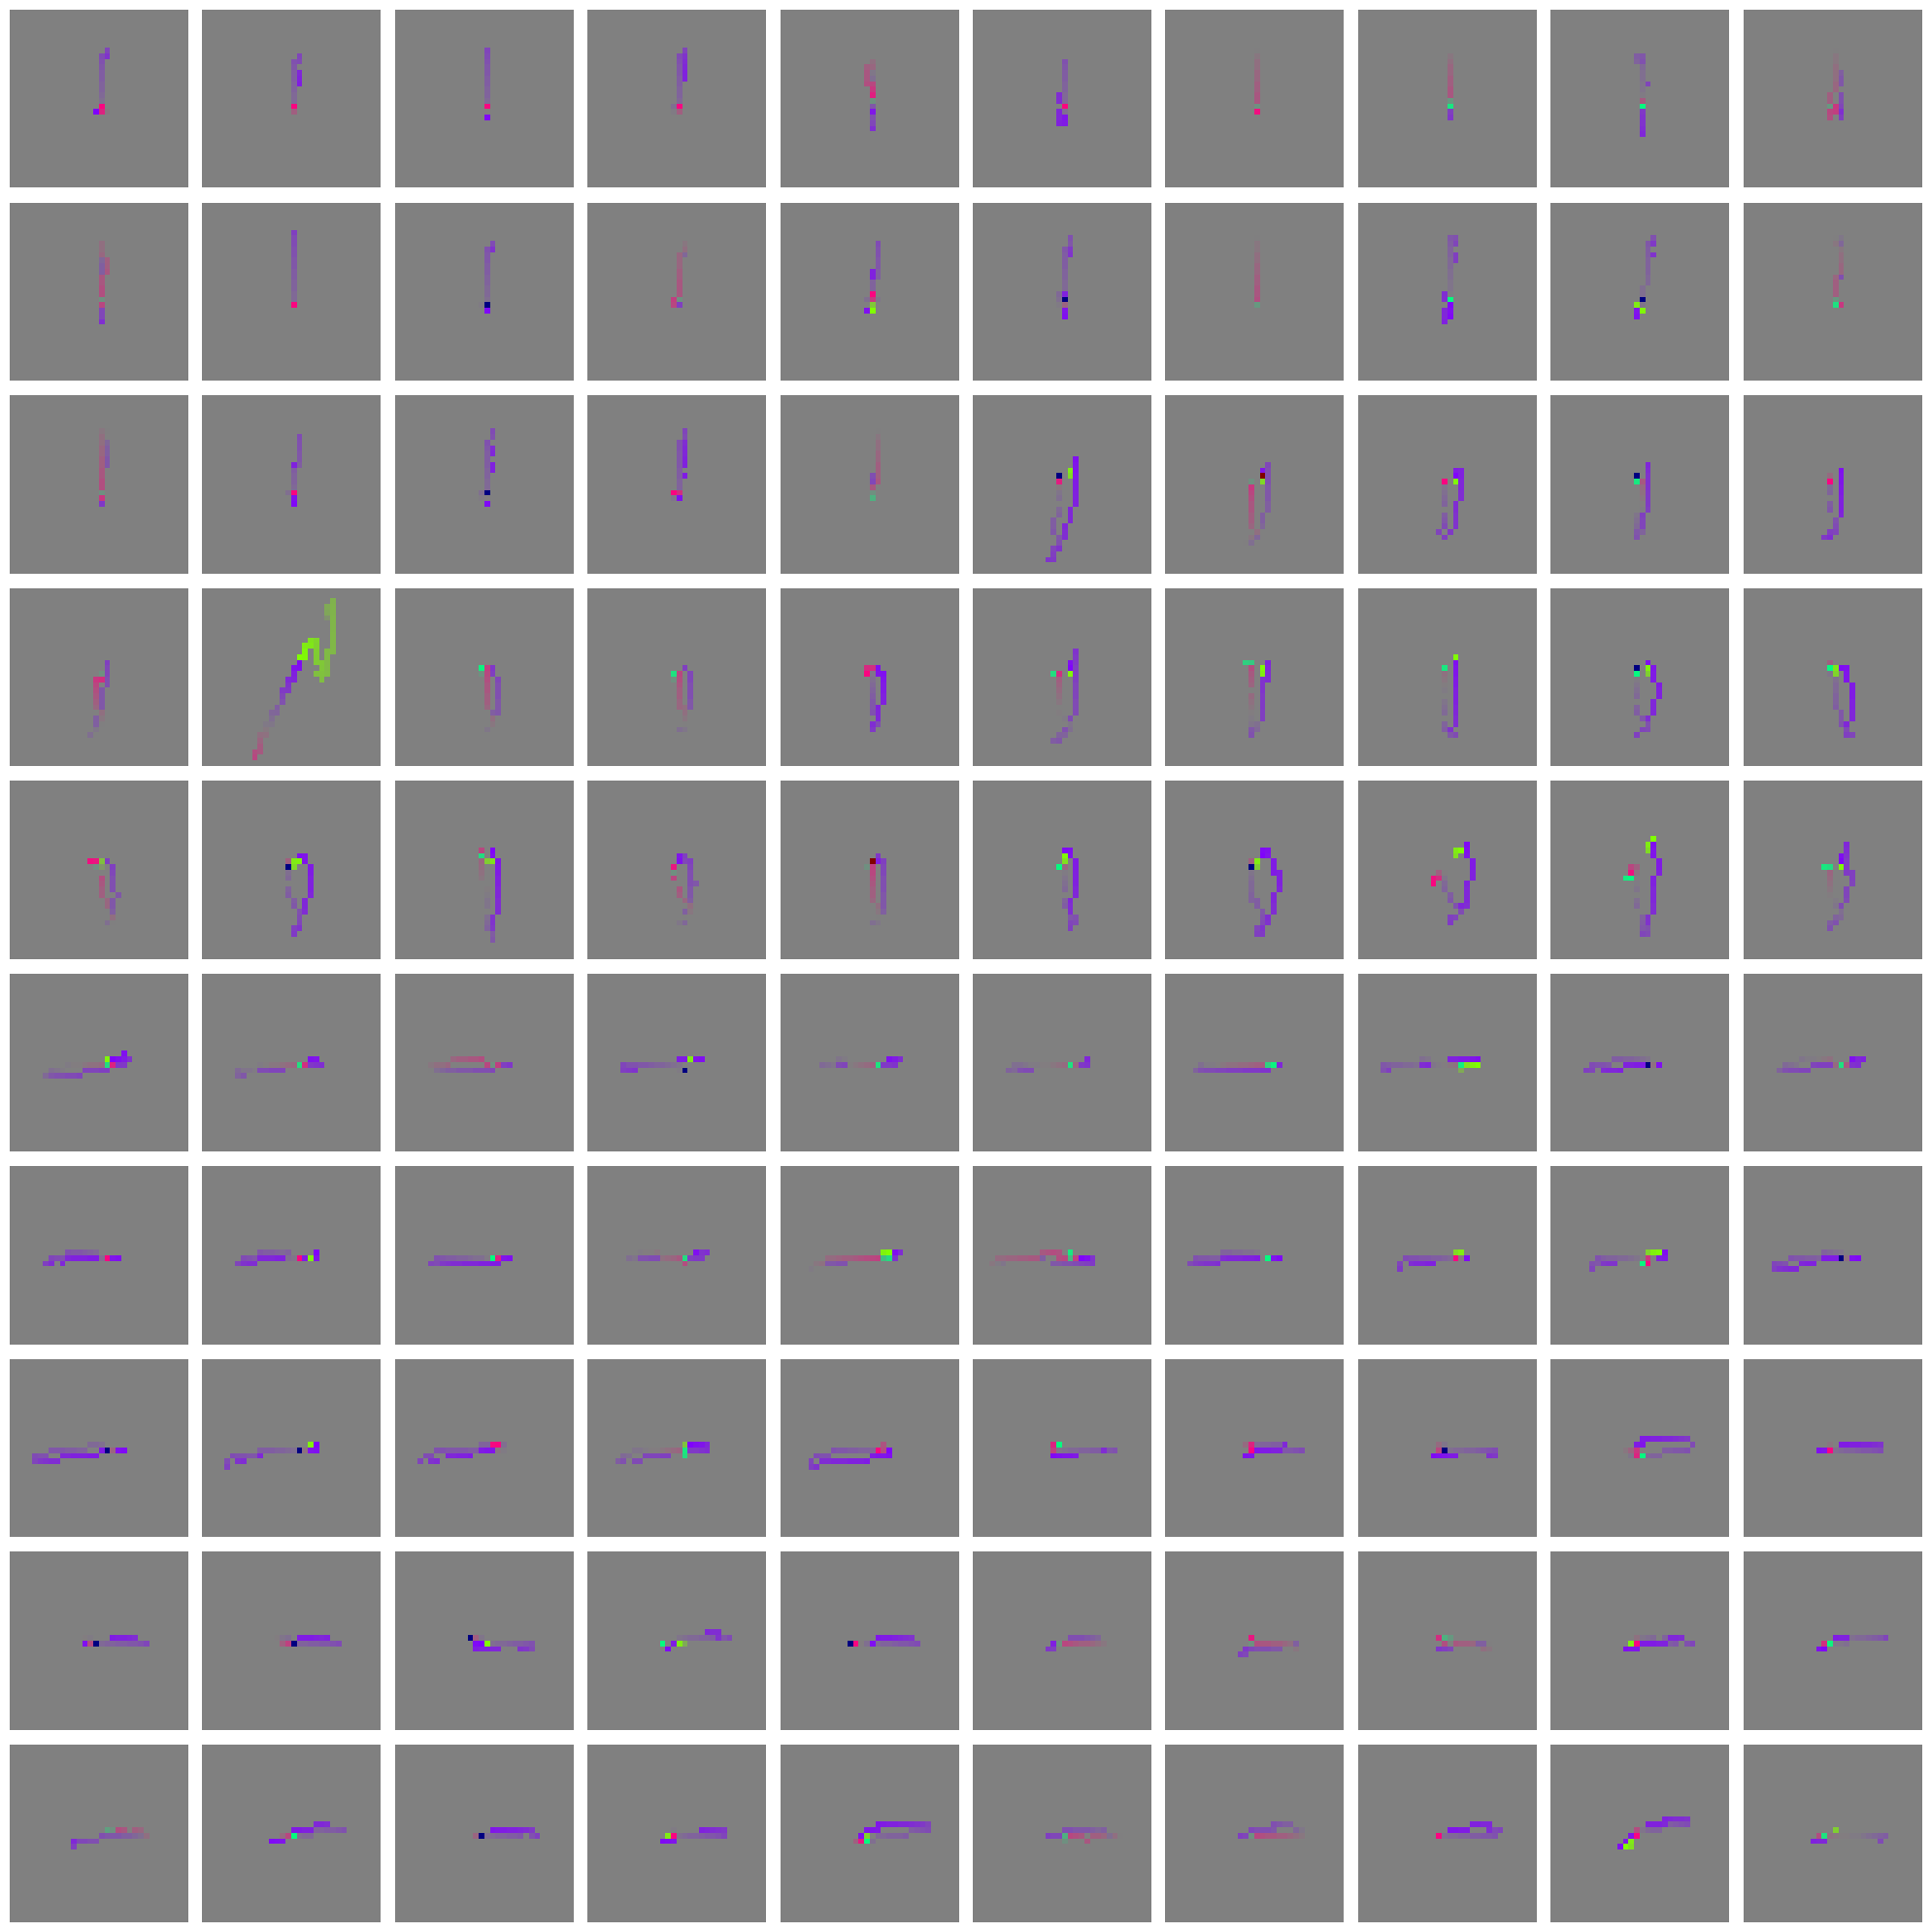

val_ds:


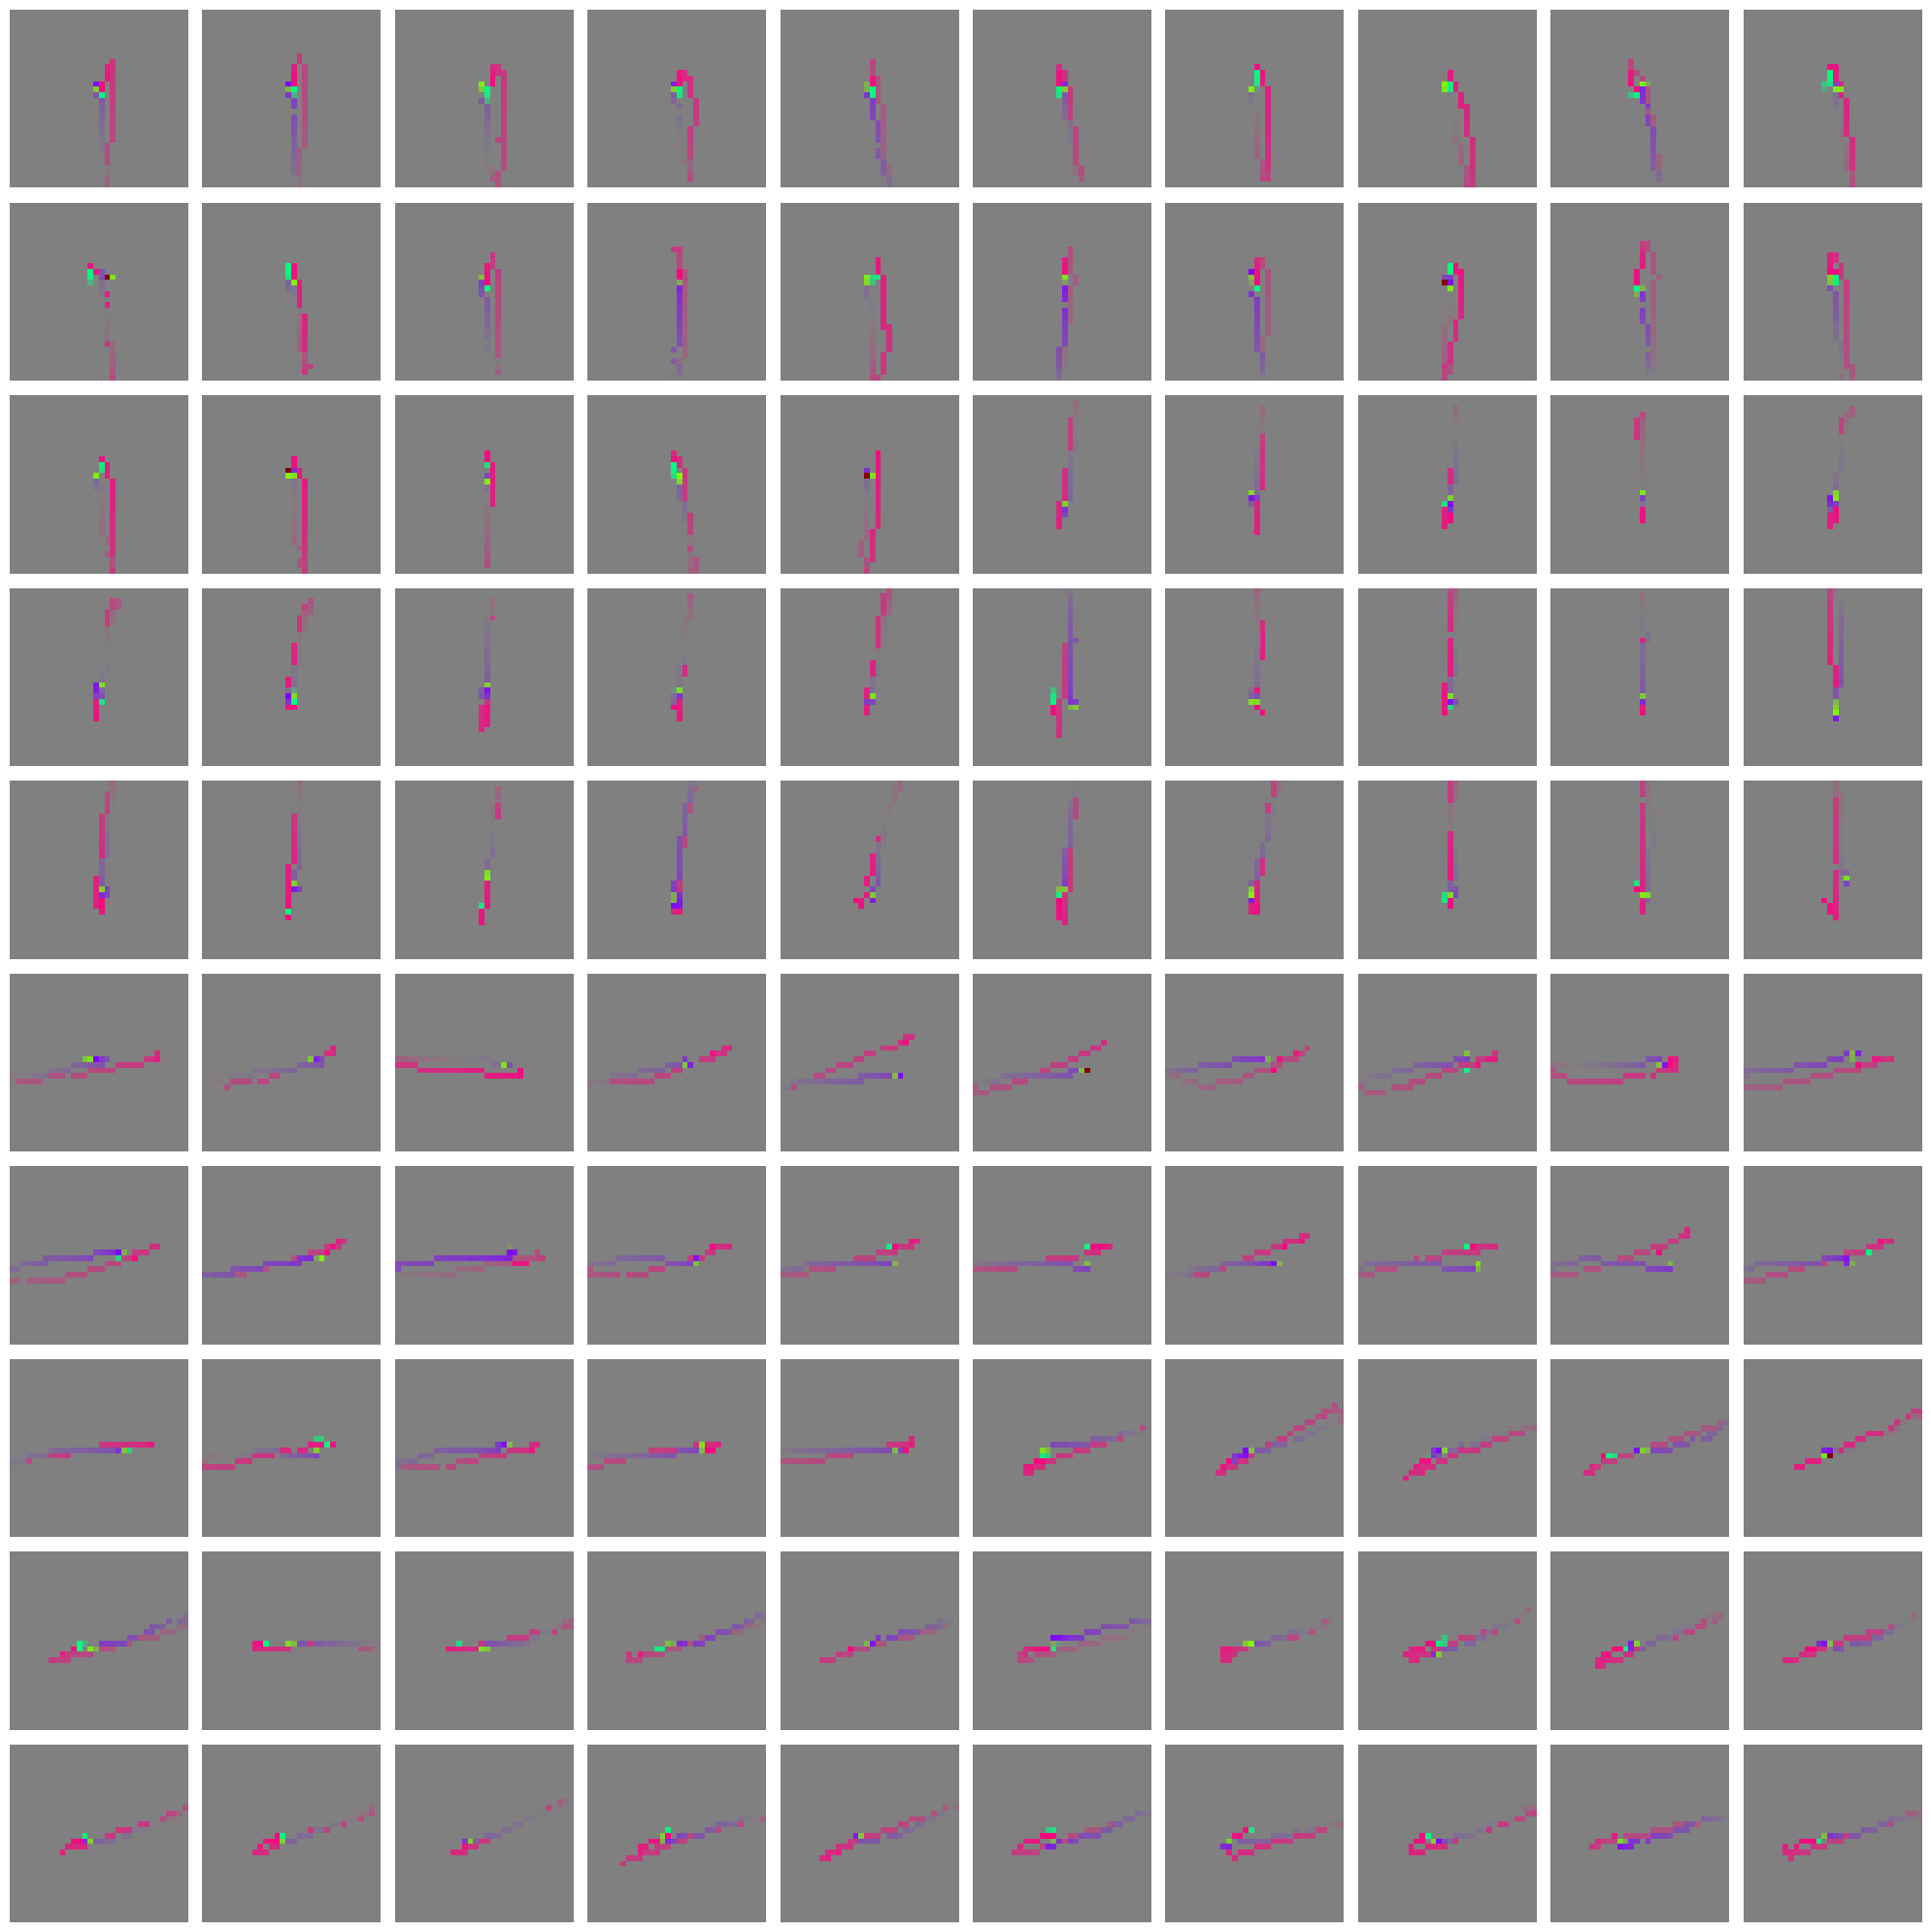

In [6]:


# Function to display images
def display_images(images, num_rows=10, num_cols=10):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(images[i])
        ax.axis('off')  # Hide axes for a cleaner look
    plt.tight_layout()
    plt.show()

# Display both datasets
print("train_ds:")
display_images(train_ds)
print("val_ds:")
display_images(val_ds)

## Define your Model

Next we will define and visualize the CNN model that we will use for the magic wand!

In [22]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = keras.layers.Rescaling(1.0 / 255)(inputs) # Removing preprocessing as rescaling is available directly under keras.layers
    x = keras.layers.Conv2D(8, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    #x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    #x = keras.layers.Dropout(0.5)(x)

    # adding either of these two layers made model to big for mc
    # x = keras.layers.Conv2D(128, 3, strides=2, padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Activation("relu")(x)
    # x = keras.layers.Dropout(0.5)(x)

    # x = keras.layers.Conv2D(256, 3, strides=2, padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Activation("relu")(x)
    # x = keras.layers.Dropout(0.5)(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    #x = keras.layers.Flatten()(x)
    # x = keras.layers.Dense(64, activation="relu")(x)
    # x = keras.layers.Dropout(0.5)(x)
    # x = keras.layers.Dense(32, activation="relu")(x)

    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=NUM_GESTURES)
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 8)         224       
                                                                 
 batch_normalization_12 (Ba  (None, 16, 16, 8)         32        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 16, 16, 8)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 16)          1168      
                                                           

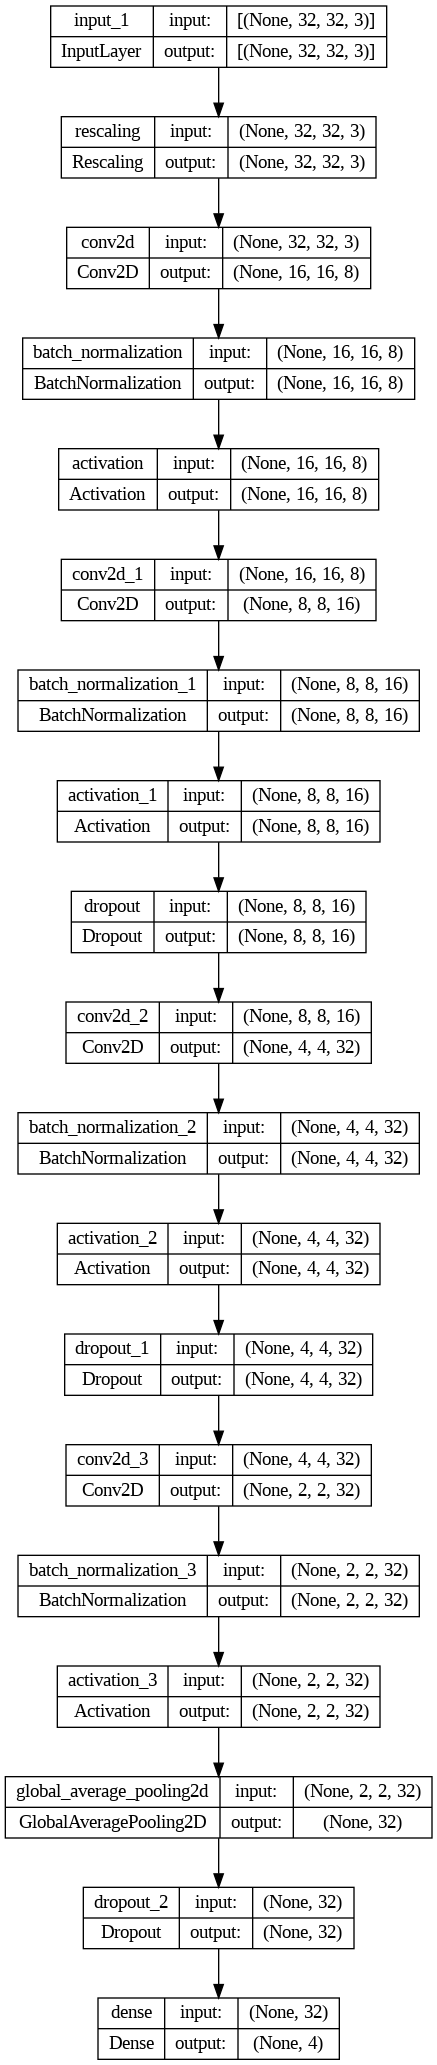

In [8]:
# View the model layers as a diagram
keras.utils.plot_model(model, show_shapes=True)

## Train your Model

Now that we have a preprocessed dataset and a model its time to train that model with that dataset!

In [23]:
# Convert training data and labels to numpy arrays
train_ds = train_ds.astype(np.uint8)
val_ds = val_ds.astype(np.uint8)
train_labels = train_labels.astype(np.uint8)
val_labels = val_labels.astype(np.uint8)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

EPOCHS = 100 # since the training is so fast, we can do many epochs

history = model.fit(train_ds, train_labels, epochs=EPOCHS, validation_data=(val_ds, val_labels))

Epoch 1/100
4/4 [==============================] - 5s 99ms/step - loss: 0.8166 - accuracy: 0.2200 - val_loss: 0.6946 - val_accuracy: 0.2500
Epoch 2/100
4/4 [==============================] - 0s 27ms/step - loss: 0.7826 - accuracy: 0.2000 - val_loss: 0.6925 - val_accuracy: 0.2500
Epoch 3/100
4/4 [==============================] - 0s 30ms/step - loss: 0.7368 - accuracy: 0.2700 - val_loss: 0.6896 - val_accuracy: 0.2500
Epoch 4/100
4/4 [==============================] - 0s 26ms/step - loss: 0.7201 - accuracy: 0.3200 - val_loss: 0.6861 - val_accuracy: 0.2500
Epoch 5/100
4/4 [==============================] - 0s 25ms/step - loss: 0.7025 - accuracy: 0.3000 - val_loss: 0.6824 - val_accuracy: 0.2500
Epoch 6/100
4/4 [==============================] - 0s 25ms/step - loss: 0.6901 - accuracy: 0.3200 - val_loss: 0.6786 - val_accuracy: 0.2500
Epoch 7/100
4/4 [==============================] - 0s 25ms/step - loss: 0.6753 - accuracy: 0.3700 - val_loss: 0.6750 - val_accuracy: 0.2500
Epoch 8/100
4/4 [===

In [25]:
# save the model file
model.save('model' + '.keras') # Added .keras extension to the filename
export_dir = 'saved_model'
tf.saved_model.save(model, export_dir)

## Generate a TensorFlow Lite Model

Convert the frozen graph into a TensorFlow Lite model, which is fully quantized for use with embedded devices. The following cell will also print the model size.

In [26]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
print(export_dir)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
    yield([train_ds.astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

saved_model


21888

Compare the sizes of the Tensorflow, TensorFlow Lite and Quantized TensorFlow Lite models.

In [27]:
def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(export_dir)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,572994 bytes,
TensorFlow Lite,65168 bytes,(reduced by 507826 bytes)
TensorFlow Lite Quantized,21888 bytes,(reduced by 43280 bytes)


## Test your TensorFlow Lite Models

Lets now test out the TFLite models (quantized and unquantized) on the test dataset. We'll print out any gesture we get wrong as well as the percentage of known gestures correct as well as the number of gestures that were marked as unknown.

In [13]:
 # Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_path="models/magic_wand.tfl")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

# Test TFLite model against training data (sanity check)
for i, img_array in enumerate(train_ds):
  img_array = [img_array.astype(np.int8)]
  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    #pred = np.multiply((pred - output_zero_point), 1)

    predicted_label_index = np.argmax(pred)
    #predicted_score = pred[predicted_label_index]
    print(f"{i}: {predicted_label_index}")

{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.9960784316062927, -128), 'quantization_parameters': {'scales': array([0.99607843], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 0
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 1
26: 1
27: 1
28: 3
29: 1
30: 0
31: 1
32: 1
33: 1
34: 1
35: 1
36: 1
37: 1
38: 1
39: 1
40: 1
41: 1
42: 1
43: 1
44: 1
45: 1
46: 1
47: 1
48: 1
49: 1
50: 2
51: 2
52: 2
53: 2
54: 2
55: 2
56: 2
57: 2
58: 2
59: 2
60: 2
61: 2
62: 2
63: 2
64: 2
65: 2
66: 2
67: 2
68: 2
69: 2
70: 2
71: 2
72: 2
73: 2
74: 2
75: 3
76: 3
77: 3
78: 3
79: 3
80: 3
81: 3
82: 3
83: 3
84: 3
85: 3
86: 3
87: 3
88: 3
89: 3
90: 3
91: 3
92: 3
93: 3
94: 3
95: 3
96: 3
97: 3
98: 3
99: 3


## Generate a TensorFlow Lite for Microcontrollers Model
To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on Arduino we simply need to use the ```xxd``` tool to convert the ```.tflite``` file into a ```.cc``` file.

In [16]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

That's it! You've successfully converted your TensorFlow Lite model into a TensorFlow Lite for Microcontrollers model! Run the cell below to print out its contents which we'll need for our next step, deploying the model using the Arudino IDE!

In [15]:
# Print the C source file
!cat {TFL_CC_MODEL_FILENAME}
# !tail {TFL_CC_MODEL_FILENAME} # run this command to just see the end of the file (aka the size)

unsigned char g_magic_wand_model_data[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x8c, 0x00, 0x00, 0x00, 0x0c, 0x01, 0x00, 0x00,
  0x04, 0x40, 0x00, 0x00, 0x14, 0x40, 0x00, 0x00, 0x90, 0x54, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0a, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x38, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x74, 0xff, 0xff, 0xff,
  0x12, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 

To download your model for use at a later date:

1. On the left of the UI click on the folder icon
2. Click on the three dots to the right of the ```.cc``` file you just generated and select "download." The file can be found at ```models/{TFL_CC_MODEL_FILENAME}``` which by default is ```models/magic_wand.cc```

Next we'll deploy that model using the Arduino IDE.